In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import warnings
from scipy.integrate import simpson, trapezoid
from scipy.interpolate import CubicSpline, UnivariateSpline
from onepower import Spectra

import SpectraWithTrapezoid
from params_benchmark import kwargs

from matplotlib import rc

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

plt.rcParams.update({'font.size': 16})

spec_names = {
    'mm': '$\mathbf{Matter-Matter}$',
    'gg': '$\mathbf{Galaxy-Galaxy}$', 
    'gm': '$\mathbf{Galaxy-Matter}$'}

In [3]:
class PowerSpectrumBenchmark:
    """
    Benchmark class for testing integration accuracy in pk.py power spectrum calculations.
    """

    def __init__(self, kwargs):
        """Initialize benchmark."""
        self.results = {}
        self.params = kwargs

    def _get_power_spectrum(self, spectra, spec_type):
        spectrum_methods = {
            'mm': spectra.power_spectrum_mm,
            'gg': spectra.power_spectrum_gg,
            'gm': spectra.power_spectrum_gm
        }
        return spectrum_methods[spec_type]

    def _test_convergence(self, quantity, values, spectra_types, param_modifier):
        """
        Method to test convergence with different resolutions.

        Parameters
        ----------
        quantity : str
            Type of quantity being tested.
        values : list
            List of quantity values to test.
        spectra_types : list
            Types of power spectra to compute ['mm', 'gg', 'gm'].
        param_modifier : function
            Function that takes (params, value) and returns modified params.

        Returns
        -------
        dict
            Results for each value and spectra type.
        """
        convergence_results = {}

        for value in values:
            print(f"  Testing {quantity} at: {value}")

            # Get modified parameters
            modified_params = param_modifier(self.params.copy(), value)

            # Create spectra with new resolution
            spectra = Spectra(**modified_params)

            # Store results for each spectra type
            value_results = {}
            for spec_type in spectra_types:
                ps_result = self._get_power_spectrum(spectra, spec_type)

                value_results[spec_type] = {
                    'pk_tot': ps_result.pk_tot,
                    'k_vec': spectra.k_vec}

                if quantity == 'mass':
                    value_results[spec_type].update({
                        'mass': spectra.mass,
                        'dlog10m': modified_params['dlog10m']})
                elif quantity == 'k':
                    value_results[spec_type]['dlnk'] = modified_params['dlnk']

            convergence_results[value] = value_results

        return convergence_results

    def _modify_mass_params(self, params, dlog10m_value):
        """Modify parameters for mass testing."""
        params['dlog10m'] = dlog10m_value
        return params

    def _modify_k_params(self, params, dlnk_value):
        """Modify parameters for k testing."""
        params['dlnk'] = dlnk_value
        return params

    def test_mass(self, dlog10m_values=[0.05, 0.01, 0.006], 
                                       spectra_types=['mm']):
        """Test convergence with different mass array resolutions."""
        return self._test_convergence(
            'mass', dlog10m_values, spectra_types, self._modify_mass_params)

    def test_k(self, dlnk_values=[0.001, 0.0001, 0.00001], 
                                    spectra_types=['mm']):
        """Test convergence with different k resolutions."""
        return self._test_convergence(
            'k', dlnk_values, spectra_types, self._modify_k_params)

    def test_integration_methods(self, integration_methods=['simpson'], spectra_types=['mm']):
        """
        Generate power spectra using different integration methods at high resolution.
        
        Parameters
        ----------
        integration_methods : list
            List of integration methods to use. Options: 'simpson', 'trapezoid'
        spectra_types : list
            Types of power spectra to compute ['mm', 'gg', 'gm'].
        """
        print(f"Generating spectra with integration methods {integration_methods} at high resolution...")
        
        high_res_spectra = {}
        high_res_params = {**self.params, 'dlog10m': 0.01, 'dlnk': 0.001}
        
        method_config = {
            'simpson': (Spectra, "simpson_high_resolution_benchmark.pkl"),
            'trapezoid': (SpectraWithTrapezoid, "trapezoid_high_resolution_benchmark.pkl")}
        
        for method_name in integration_methods:
            spectra_class, filename = method_config[method_name]
            
            if os.path.exists(filename):
                with open(filename, 'rb') as f:
                    saved_results = pickle.load(f)
                
                for spec_type in spectra_types:
                    if spec_type not in high_res_spectra:
                        high_res_spectra[spec_type] = {}
                    
                    high_res_spectra[spec_type][method_name] = {
                        'pk_tot': saved_results['spectra_results'][spec_type]['pk_tot'],
                        'k_vec': saved_results['k_vec']}
            else:
                print(f"Computing {method_name} results...")
                spectra = spectra_class(**high_res_params)
                results_to_save = {}
                
                for spec_type in spectra_types:
                    print(f"    Computing {method_name} {spec_type} spectra...")
                    result = getattr(spectra, f'power_spectrum_{spec_type}')
                    
                    if spec_type not in high_res_spectra:
                        high_res_spectra[spec_type] = {}
                    
                    high_res_spectra[spec_type][method_name] = {
                        'pk_tot': result.pk_tot,
                        'k_vec': spectra.k_vec}
                    
                    results_to_save[spec_type] = result
                
                self.save_to_file(high_res_params, results_to_save, spectra, filename)
        
        return high_res_spectra

    def save_to_file(self, parameters, spectra_results, spectra, filename):
        """
        Save results to file.
        
        Parameters
        ----------
        parameters : dict
            Parameters used for computation
        spectra_results : dict
            Dictionary with keys 'mm', 'gg', 'gm' containing power spectrum results
        spectra : object
            Spectra object containing k_vec, z_vec, mass
        filename : str
            Filename to save to
        """
        # Save results for all spectra types
        results = {
            'params': parameters,
            'spectra_results': {},
            'k_vec': spectra.k_vec,
            'z_vec': spectra.z_vec,
            'mass': spectra.mass}
        
        # Save each spectra type
        for spec_type, ps_result in spectra_results.items():
            results['spectra_results'][spec_type] = {
                'pk_tot': ps_result.pk_tot,
                'pk_1h': ps_result.pk_1h,
                'pk_2h': ps_result.pk_2h}
        
        with open(filename, 'wb') as f:
            pickle.dump(results, f)
        
        return

  Testing mass at: 0.05
  Testing mass at: 0.01
  Testing mass at: 0.006


python(2437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2443) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2444) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2445) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2446) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2449) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


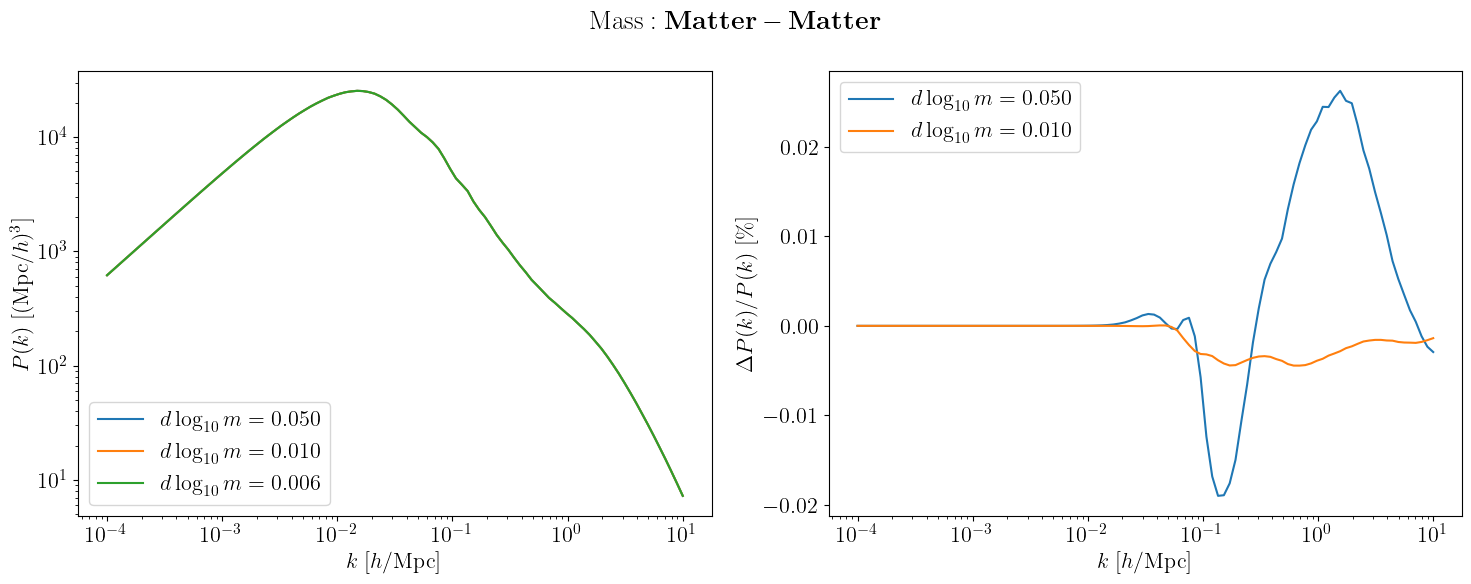

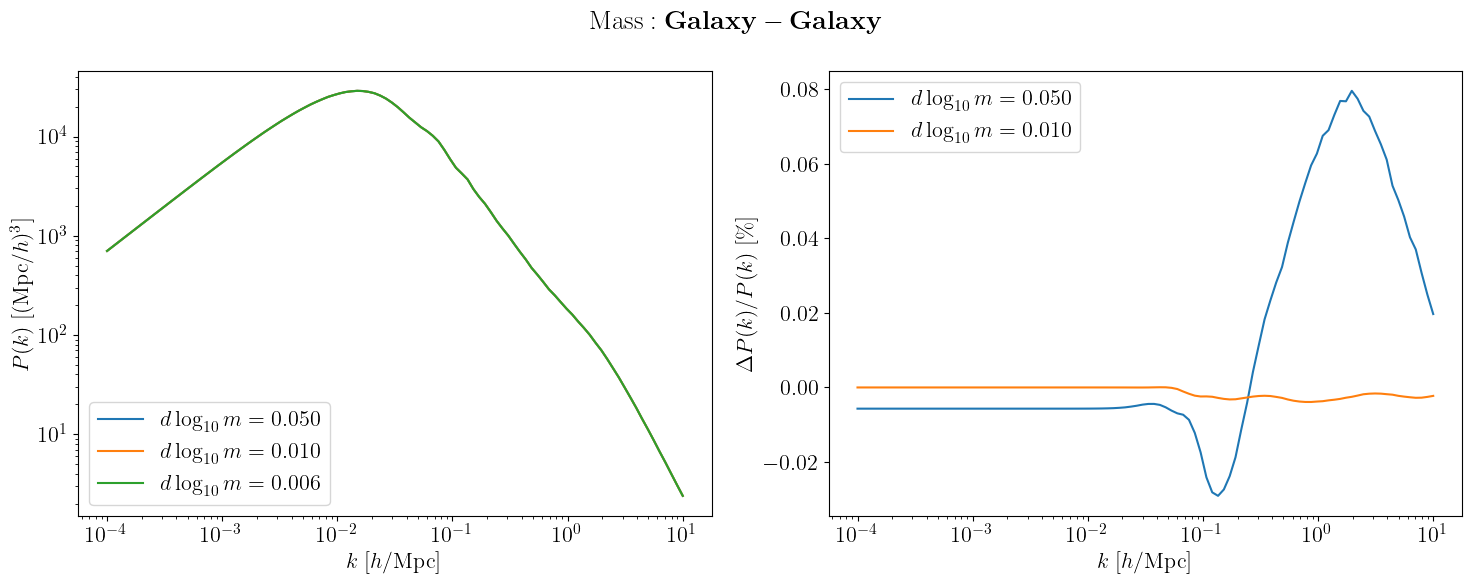

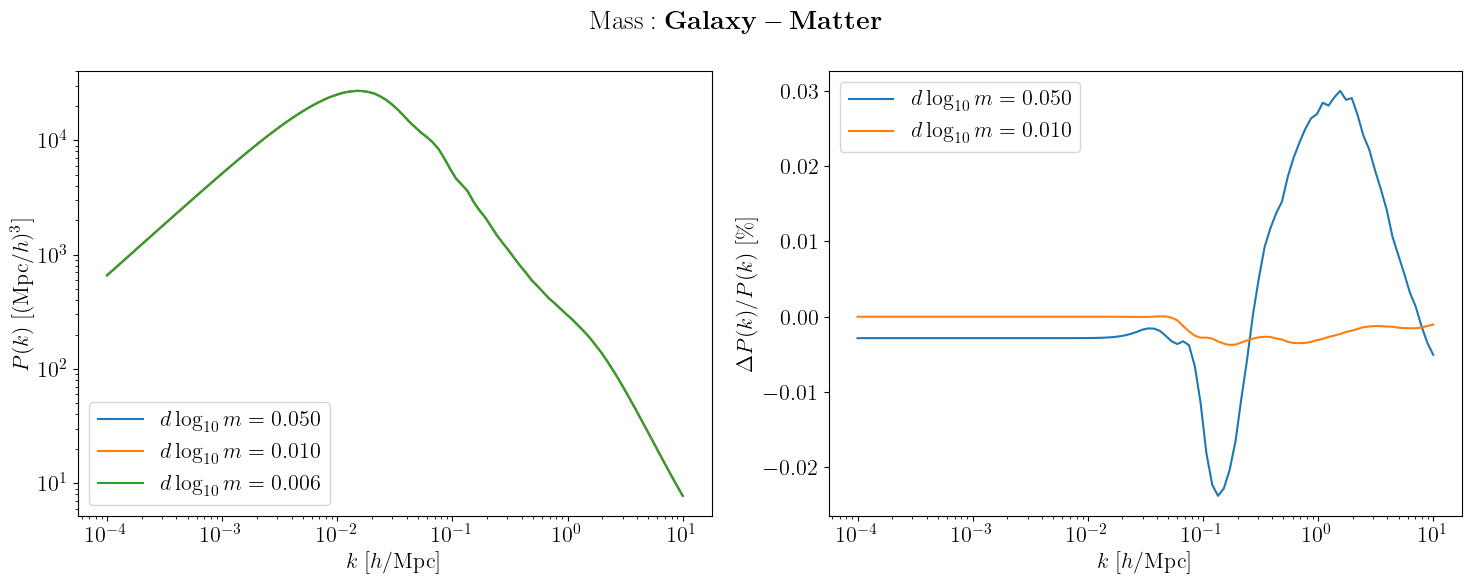

In [5]:
benchmark = PowerSpectrumBenchmark(kwargs)

spectra_types=['mm', 'gg', 'gm']
dlog10m_values = [0.05, 0.01, 0.006]

mass_results = benchmark.test_mass(
    dlog10m_values=dlog10m_values, 
    spectra_types=spectra_types)

k_vec = mass_results[0.05]['mm']['k_vec']
for spec_type in spectra_types:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    for dlog10m_val in dlog10m_values:
        pk_tot = mass_results[dlog10m_val][spec_type]['pk_tot'][0, 0, :]
        dlog10m = mass_results[dlog10m_val][spec_type]['dlog10m']
        ax1.loglog(k_vec, pk_tot, label=rf'$d\log_{{10}}m={dlog10m:.3f}$')
    ax1.set(
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")
    ax1.legend()
    
    ref_dlog10m = min(dlog10m_values)
    ref_pk = mass_results[ref_dlog10m][spec_type]['pk_tot'][0, 0, :]
    
    for dlog10m_val in dlog10m_values:
        if dlog10m_val != ref_dlog10m:
            pk_tot = mass_results[dlog10m_val][spec_type]['pk_tot'][0, 0, :]
            rel_error = (pk_tot - ref_pk) / ref_pk * 100
            ax2.semilogx(k_vec, rel_error, label=rf'$d\log_{{10}}m={dlog10m_val:.3f}$')
    ax2.set(
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$\Delta P(k) / P(k)\ [\%]$")
    ax2.legend()
    
    fig.suptitle(rf'$\mathrm{{Mass:\ }}${spec_names[spec_type]}')

    plt.tight_layout()
    plt.savefig(f'Mass_test_{spec_type}.pdf', bbox_inches='tight', dpi=300)
    
plt.show()

  Testing k at: 0.001
  Testing k at: 0.0001
  Testing k at: 1e-05


python(2460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


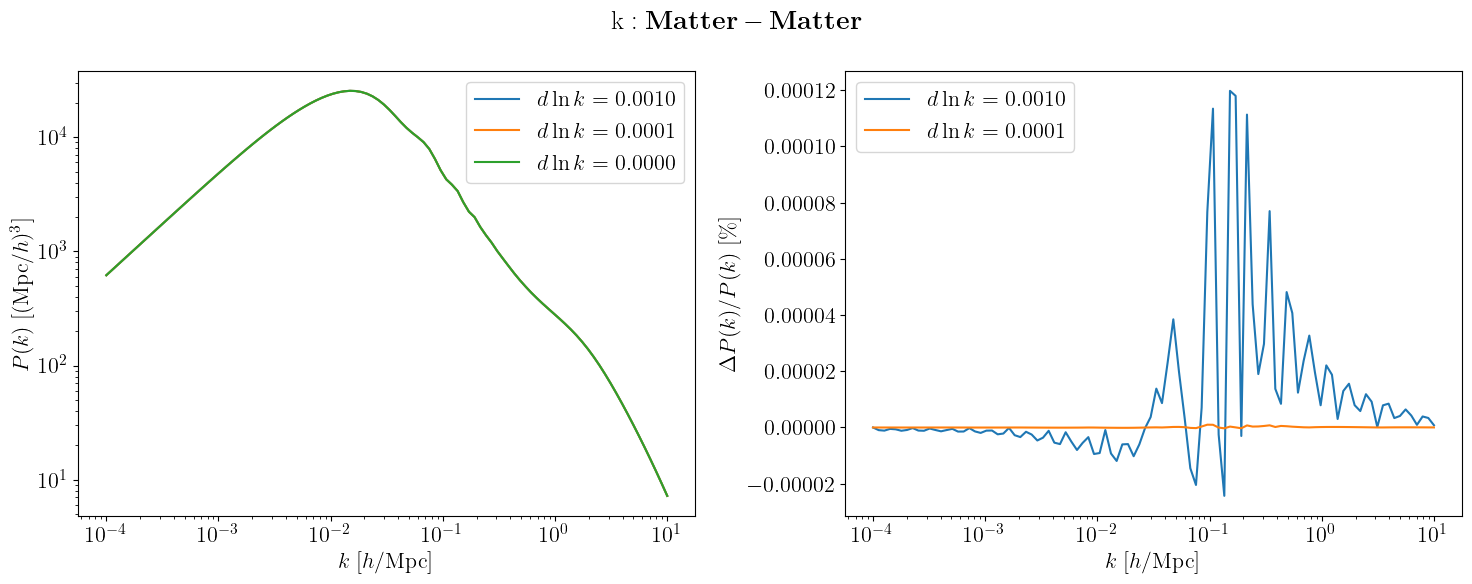

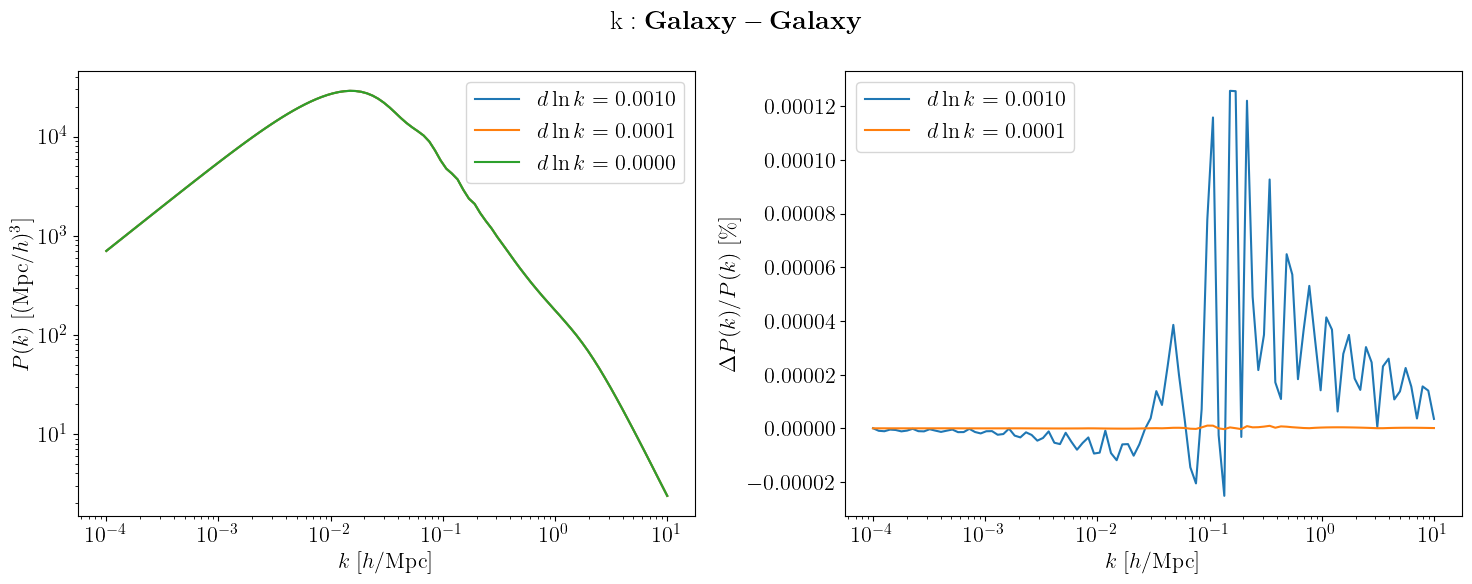

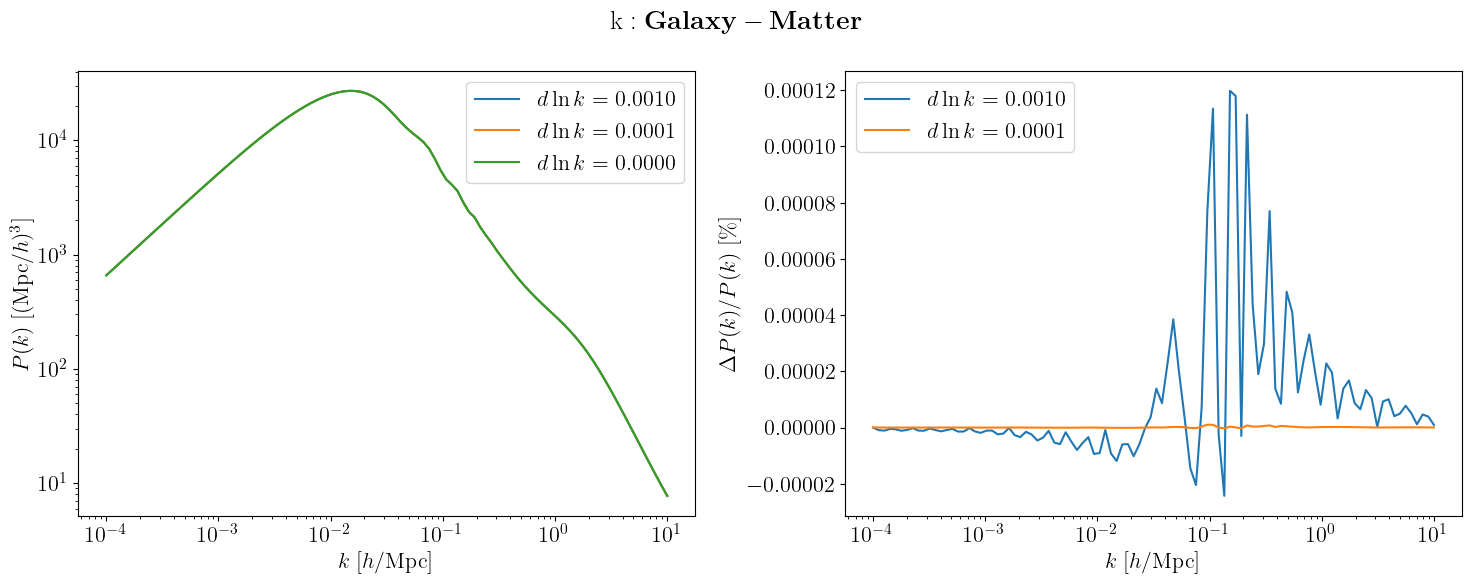

In [6]:
benchmark = PowerSpectrumBenchmark(kwargs)
spectra_types = ['mm', 'gg', 'gm']
dlnk_values = [0.001, 0.0001, 0.00001]
k_results = benchmark.test_k(
    dlnk_values=dlnk_values, 
    spectra_types=spectra_types)

k_vec = k_results[0.001]['mm']['k_vec']

for spec_type in spectra_types:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    for dlnk_val in dlnk_values:
        pk_tot = k_results[dlnk_val][spec_type]['pk_tot'][0, 0, :]
        dlnk = k_results[dlnk_val][spec_type]['dlnk']
        ax1.loglog(k_vec, pk_tot, label=rf'$d\ln k={dlnk:.4f}$')
    ax1.set(
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")
    ax1.legend()
    
    ref_dlnk = min(dlnk_values)
    ref_pk = k_results[ref_dlnk][spec_type]['pk_tot'][0, 0, :]
    
    for dlnk_val in dlnk_values:
        if dlnk_val != ref_dlnk:
            pk_tot = k_results[dlnk_val][spec_type]['pk_tot'][0, 0, :]
            rel_error = (pk_tot - ref_pk) / ref_pk * 100
            ax2.semilogx(k_vec, rel_error, label=rf'$d\ln k={dlnk_val:.4f}$')
    ax2.set(
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$\Delta P(k) / P(k)\ [\%]$")
    ax2.legend()
    
    fig.suptitle(rf'$\mathrm{{k:\ }}${spec_names[spec_type]}')
    plt.tight_layout()
    plt.savefig(f'K_test_{spec_type}.pdf', bbox_inches='tight', dpi=300)
    
plt.show()

Generating spectra with integration methods ['simpson', 'trapezoid'] at high resolution...


python(2468) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2473) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


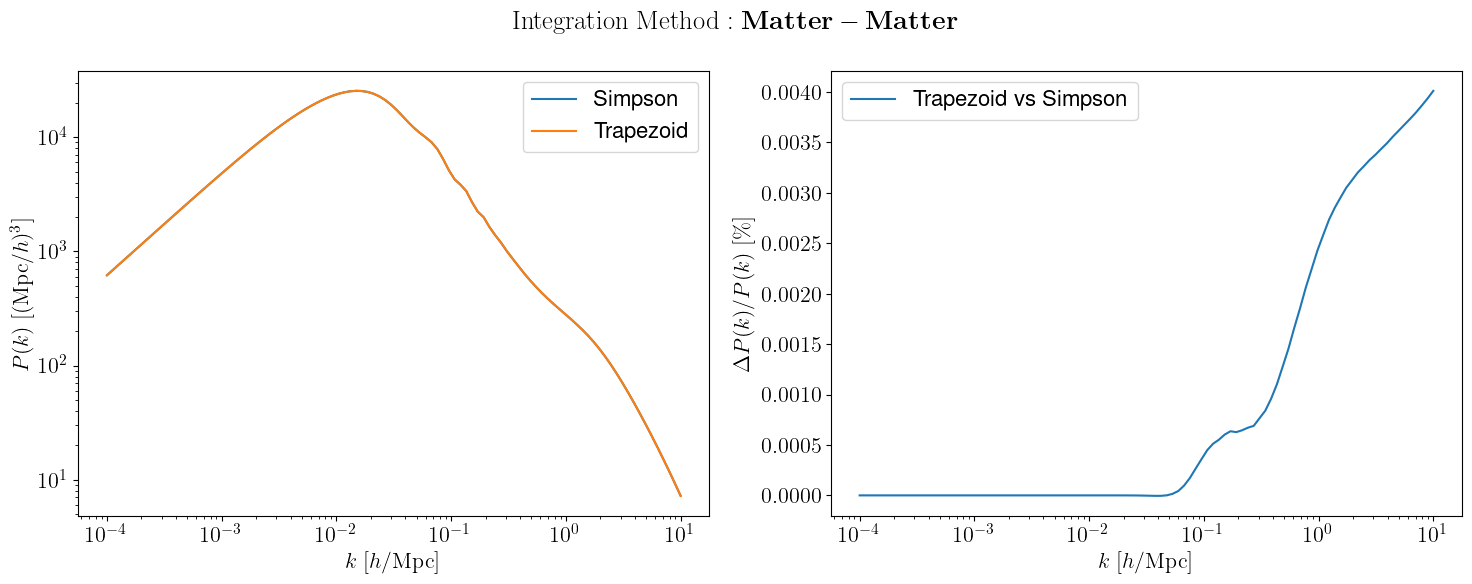

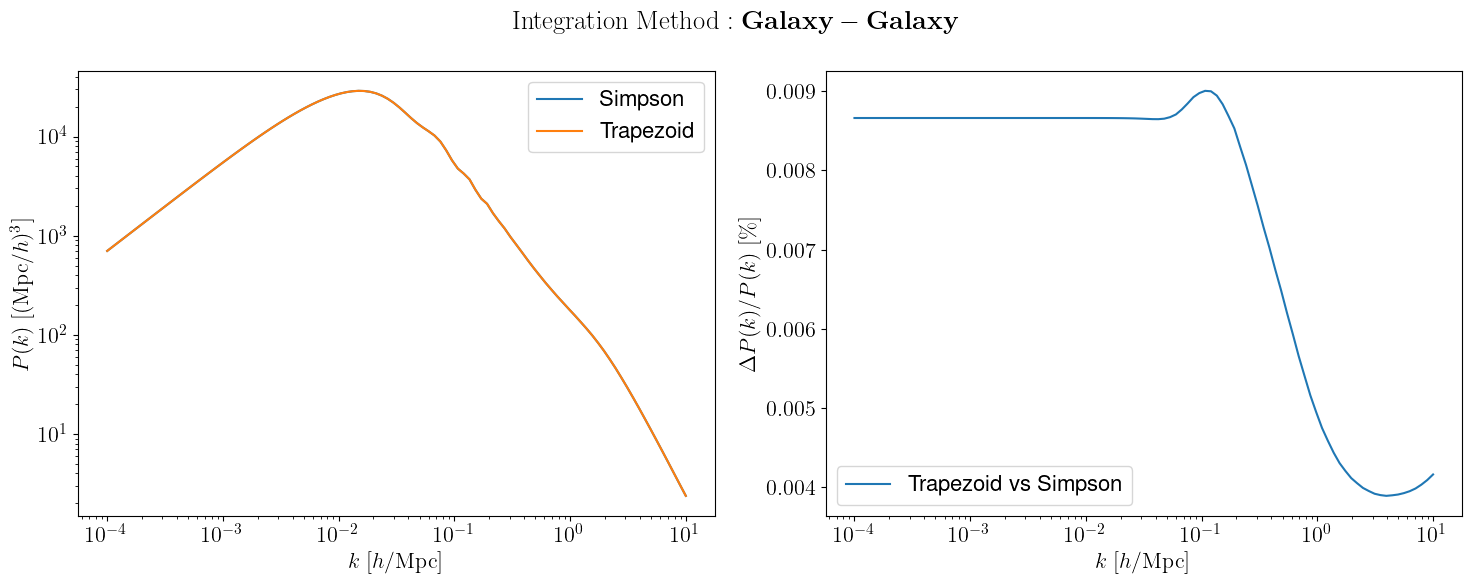

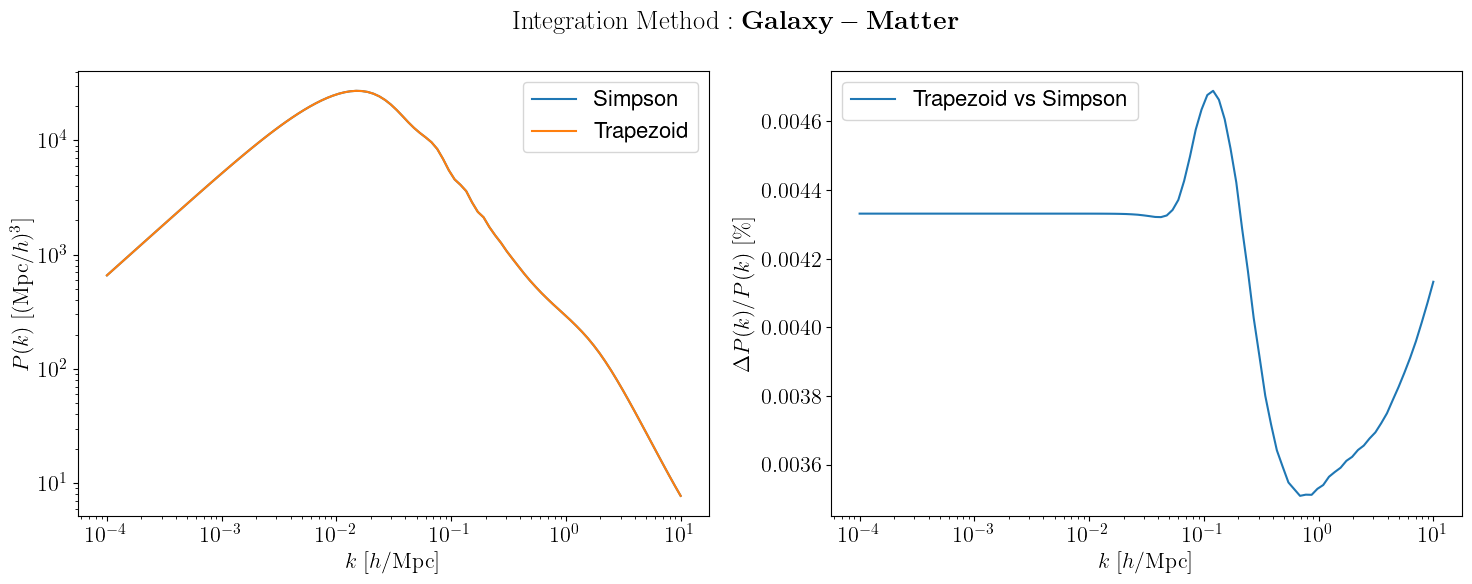

In [7]:
benchmark = PowerSpectrumBenchmark(kwargs)
spectra_types = ['mm', 'gg', 'gm']
integration_results = benchmark.test_integration_methods(
    integration_methods=['simpson', 'trapezoid'], 
    spectra_types=spectra_types)

k_vec = integration_results['mm']['simpson']['k_vec']

for spec_type in spectra_types:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    simpson_pk = integration_results[spec_type]['simpson']['pk_tot'][0, 0, :]
    trapezoid_pk = integration_results[spec_type]['trapezoid']['pk_tot'][0, 0, :]
    
    ax1.loglog(k_vec, simpson_pk, label='Simpson')
    ax1.loglog(k_vec, trapezoid_pk, label='Trapezoid')
    ax1.set(
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")
    ax1.legend()
    
    rel_error = (trapezoid_pk - simpson_pk) / simpson_pk * 100
    ax2.semilogx(k_vec, rel_error, label='Trapezoid vs Simpson')
    ax2.set(
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$\Delta P(k) / P(k)\ [\%]$")
    ax2.legend()
    
    fig.suptitle(rf'$\mathrm{{Integration\ Method:\ }}${spec_names[spec_type]}')
    plt.tight_layout()
    plt.savefig(f'Integration_method_test_{spec_type}.pdf', bbox_inches='tight', dpi=300)
    
plt.show()